# Chargement des données

In [1]:
import pandas as pd 
data = {
    'train' : None
    #'val' : None,
    #'test' : None
}
for df_name in data.keys():
    data[df_name] = pd.read_csv(f"final_dataset/{df_name}.csv", sep='~')

In [2]:
data['train'].head()

,note,contenu,sentiment
0,1.0,Reçu le prix spécial du jury au Festival du fi...,0
1,2.0,C’est une petite révolution qui s’est déroulée...,0
2,3.0,Je m'attendias à pire . . au final un bon film...,1
3,1.5,Un film québécois avec le français et l'intona...,0
4,0.5,"Un feel good movie vu et revu, accumulant les ...",0


# Custom vocab and tokenization

**Idée :**
Utilisation de tokenizer déjà existant (spacy `fr_core_news_sm`) pour:
- Enlever les stop words.
- Enlever la ponctuation
- Enlever les NER (`Personne`, `Loc`, `Org`, `Date` etc..).
- garder le lemma et pas le mot brut pour mieux géneraliser 

In [3]:
sample_data = [data['train']['contenu'].iloc[i] for i in range(10)]

## Load spacy model

In [4]:
import spacy
nlp = spacy.load("fr_core_news_sm")

## First test

In [5]:
doc = nlp(sample_data[0])

for token in doc:
    print(token.text, token.lemma_,  token.pos_, token.is_stop)

Reçu recevoir VERB False
le le DET True
prix prix NOUN False
spécial spécial ADJ False
du de ADP True
jury jury NOUN False
au au ADP True
Festival festival NOUN False
du de ADP True
film film NOUN False
de de ADP True
comédie comédie NOUN False
de de ADP True
l' le DET True
Alpe alpe NOUN False
d' de ADP True
Huez Huez PROPN False
! ! PUNCT False
! ! PUNCT False
OK ok NOUN False
merci merci NOUN True
Why Why PROPN False
? ? PUNCT False
! ! PUNCT False
! ! PUNCT False
Mal mal ADV False
joué jouer VERB False
pour pour ADP True
l' le DET True
ensemble ensemble NOUN False
grâce grâce NOUN False
à à ADP True
une un DET True
mise mise NOUN False
en en ADP True
scène scène NOUN False
catastrophique catastrophique ADJ False
. . PUNCT False
Très très ADV True
peu peu ADV True
de de ADP True
rire rire NOUN False
dans dans ADP True
la le DET True
salle salle NOUN False
pour pour ADP True
être être AUX True
honnête honnête VERB False
( ( PUNCT False
donc donc ADV True
pas pas ADV True
seul seul AD

In [6]:
# Print named entities with token positions
for ent in doc.ents:
    print(f"Entity: '{ent.text}' | Label: {ent.label_} | Start Token: {ent.start} | End Token: {ent.end}")


Entity: 'Festival du film de comédie' | Label: MISC | Start Token: 7 | End Token: 12
Entity: 'l'Alpe d'Huez' | Label: LOC | Start Token: 13 | End Token: 17
Entity: 'OK merci' | Label: MISC | Start Token: 19 | End Token: 21
Entity: 'Why' | Label: LOC | Start Token: 21 | End Token: 22
Entity: 'Uzan' | Label: MISC | Start Token: 164 | End Token: 165


In [7]:
# test 
def preprocess(text : str)->str:
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    # first on remove les NER
    for ent in doc.ents:
        for i in range(ent.end-ent.start):
            tokens[i+ent.start] = False

    # après la ponctuation et les stop_words
    for i, token in enumerate(doc):
        if token.is_stop or token.pos_ == 'PUNCT':
            tokens[i] = False 
        elif token.lemma_== '/': # CCONJ mais pas stop word
            tokens[i] = False

    tokens = [tokens[i] for i in range(len(tokens)) if tokens[i] != False]
    assert len(tokens) >= 1
    
    return " ".join(tokens)
print('text before :', sample_data[0])
new_text = preprocess(sample_data[0])
print('new tokens :', new_text)

text before : Reçu le prix spécial du jury au Festival du film de comédie de l'Alpe d'Huez ! ! OK merci Why ? ! ! Mal joué pour l'ensemble grâce à une mise en scène catastrophique . Très peu de rire dans la salle pour être honnête (donc pas seul) . Des situations complètement ridicules où règne surtout des pitreries spoiler: alcoolisées , au final très banales et pathétiques ( spoiler: un père qui se fait traité de con par sa fille, un frère qui devient zoophile sous acide en soirée, nostalgie amoureuse dans une boite échangiste etc voilà le niveau humoriste ) le problème c'est que c'est mal scénarisé où absolument tout tombe à plat . Beaucoup d'indulgence pour ce petit film avec beaucoup trop de défauts je trouve . Une étoiles pour le petit parfum de tendresse nostalgique pour quinquas et d'optimisme qui se dégage laborieusement de ce premier film de Uzan .
new tokens : recevoir prix spécial jury mal jouer ensemble grâce mise scène catastrophique rire salle honnête situation complètem

## Analyse de l'impact des mots sur le sentiment

### Idée sur un sample

On travaille ici sur un sample de train (pour tester)

In [8]:
# at this point check top words
from collections import Counter
# create a sample to avoid long time
df = data['train'][:500].copy()
df.head()


,note,contenu,sentiment
0,1.0,Reçu le prix spécial du jury au Festival du fi...,0
1,2.0,C’est une petite révolution qui s’est déroulée...,0
2,3.0,Je m'attendias à pire . . au final un bon film...,1
3,1.5,Un film québécois avec le français et l'intona...,0
4,0.5,"Un feel good movie vu et revu, accumulant les ...",0


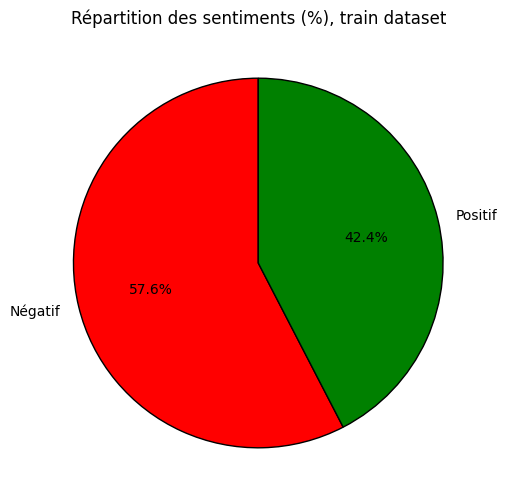

In [9]:
import matplotlib.pyplot as plt
# Calculer la distribution des sentiments
sentiment_counts = df["sentiment"].value_counts(normalize=True) * 100  # Convertir en pourcentage

# Création du camembert (pie chart)
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts, 
    labels=["Négatif", "Positif"], 
    autopct="%1.1f%%",  # Affichage des pourcentages avec 1 décimale
    colors=["red", "green"],  # Couleurs : rouge pour négatif, vert pour positif
    startangle=90,  # Commencer à 90° pour un meilleur visuel
    wedgeprops={"edgecolor": "black"}  # Bordures noires pour améliorer la lisibilité
)

# Ajouter un titre
plt.title("Répartition des sentiments (%), train dataset")

# Afficher le graphique
plt.show()

Distribution équivalente au jeu complet

In [10]:
df['cleaned_contenu'] = df['contenu'].map(preprocess) # prend du temps

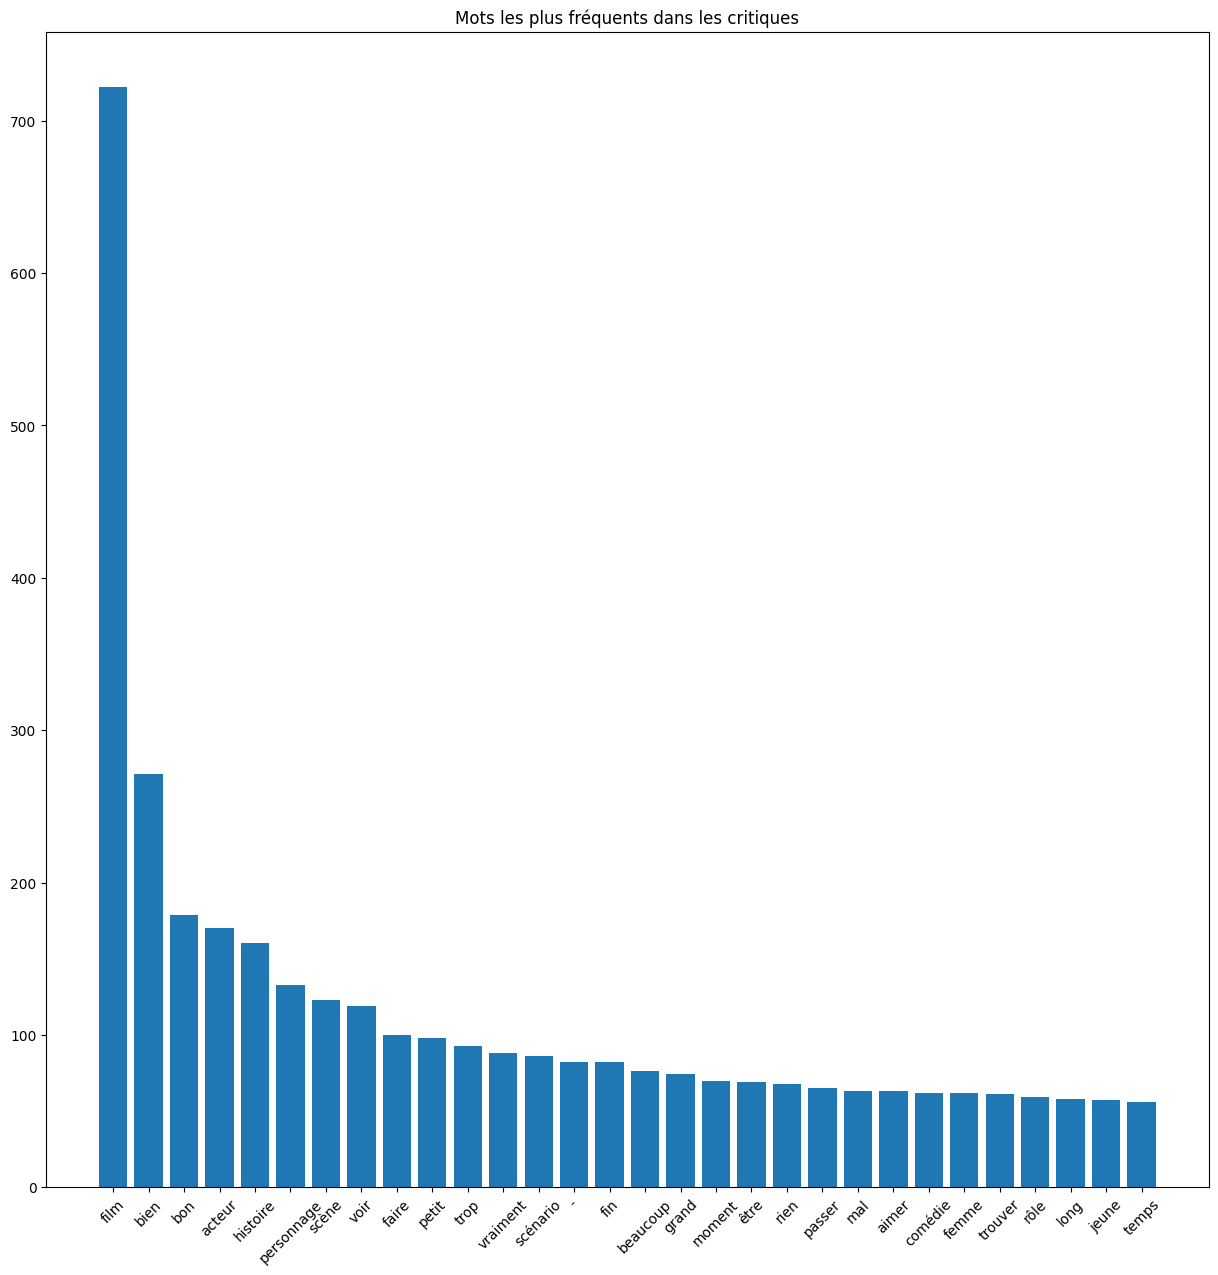

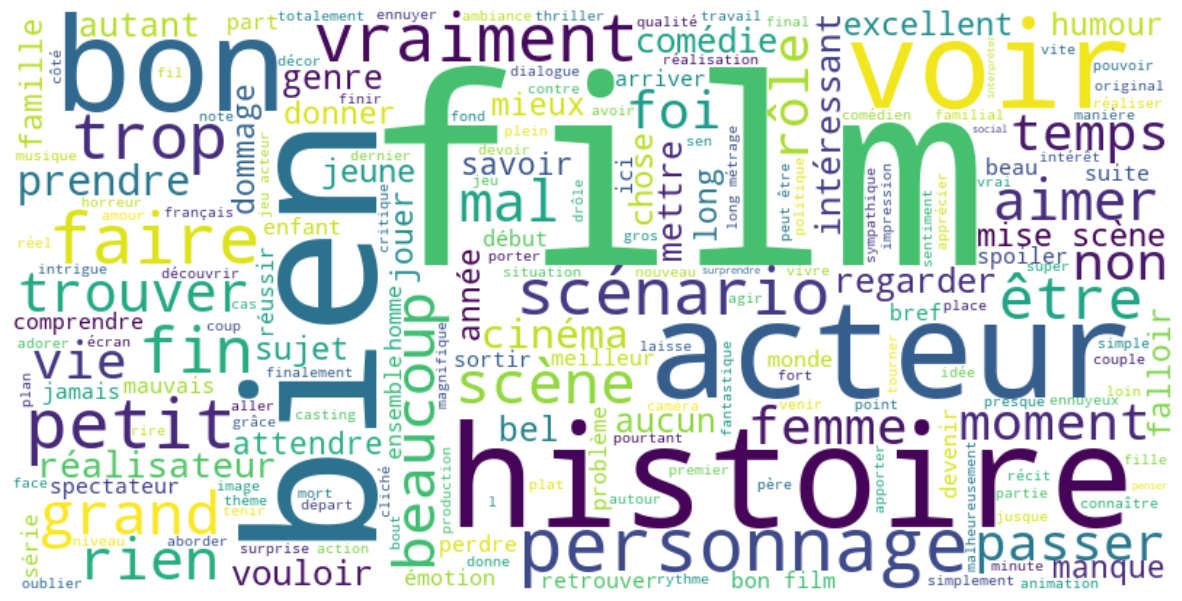

In [11]:
from wordcloud import WordCloud
def lower(text):
    return text.lower()

all_words = " ".join(df['cleaned_contenu'].map(lower)).split()
word_freq = Counter(all_words)
# Affichage des mots les plus fréquents
most_common_words = word_freq.most_common(30)
words, counts = zip(*most_common_words)
plt.figure(figsize=(15, 15))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Mots les plus fréquents dans les critiques")
plt.show()

# Génération d'un WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Avec cette visualisation, on récupère les mots communs. Certains de ces mots semblent factuels et ont potentiellement aucun impact sur le sentiment final (`TF-IDF` ne prend pas en compte le contexte).

**Idée :**  
- Vérifier les mots les plus fréquents qui ont peu d'impact sur le sentiment final.  
- Si c'est le cas, nous les supprimerons lors du prétraitement.  

In [12]:
from tqdm import tqdm
def wordBalancedOnSentiment(word_freq :list, df : pd.DataFrame, top=None):
    words_count = {} 
    for j in tqdm(range(df.shape[0])):
        words = df['cleaned_contenu'].iloc[j].lower().split() # the already preprocess one 
        for word in words:
            if word not in words_count:
                words_count[word] = [0 for _ in range(df.shape[0])]
            words_count[word][j] += 1

    if not top:  
        words_count['__sentiment__'] = df['sentiment'].copy()
        return pd.DataFrame(words_count)
    
    new_words_count = {'__sentiment__' : df['sentiment'].copy()}
    stop_range = min(len(word_freq), top) 
    for i in tqdm(range(stop_range)):
        word = word_freq[i][0]
        new_words_count[word] = words_count[word]
    return pd.DataFrame(new_words_count)

In [13]:
df_words = wordBalancedOnSentiment(list(word_freq.items()), df, 30)
df_words.head()

100%|██████████| 30/30 [00:00<?, ?it/s]


,__sentiment__,recevoir,prix,spécial,jury,mal,jouer,ensemble,grâce,mise,...,alcoolisée,final,banal,pathétique,père,traiter,con,fille,frère,devenir
0,0,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\matte\AppData\Local\Temp\ipykernel_27884\4088280724.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")


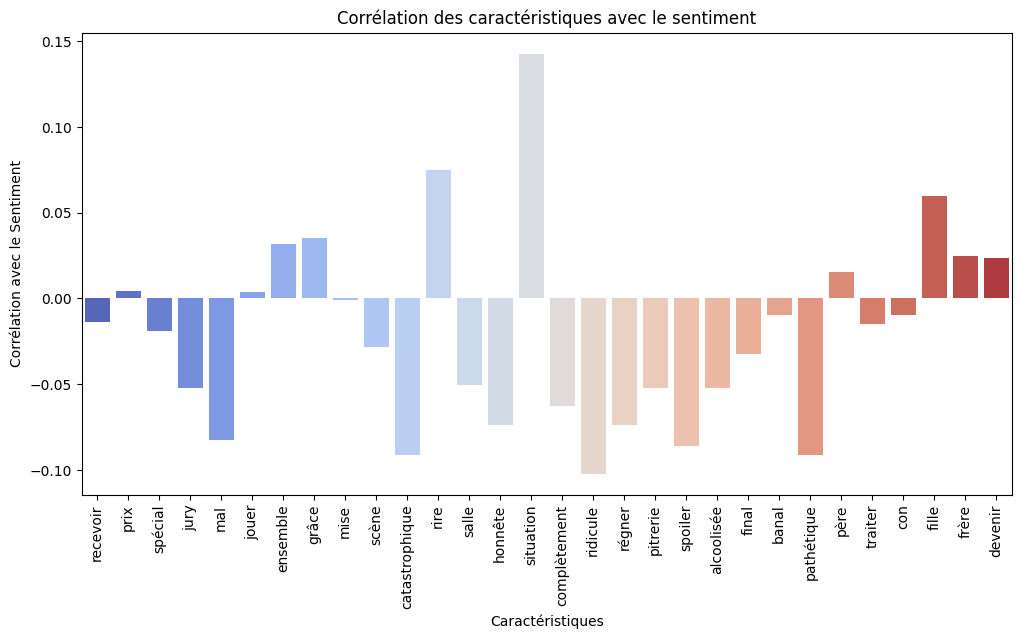

In [14]:
import seaborn as sns

# Calculer la corrélation de toutes les colonnes avec __sentiment__
corr = df_words.corr()["__sentiment__"].drop("__sentiment__")

# Tracer un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")

# Faire pivoter les étiquettes de l'axe X pour améliorer la lisibilité
plt.xticks(rotation=90)
plt.xlabel("Caractéristiques")
plt.ylabel("Corrélation avec le Sentiment")
plt.title("Corrélation des caractéristiques avec le sentiment")

# Afficher le graphique
plt.show()

**Interprétation :**
- Corrélation forte (positive ou négative) : Le mot est important pour le sentiment.
- Corrélation faible ou proche de 0 : Le mot ne pèse pas beaucoup sur le sentiment.

In [15]:
corr.describe()

count    30.000000
mean     -0.019442
std       0.056179
min      -0.102140
25%      -0.060018
50%      -0.017077
75%       0.012600
max       0.142793
Name: __sentiment__, dtype: float64

**Mon Avis :**
L'idée de supprimer les mots dont la corrélation est proche de 0 peut être utile si on veut réduire la complexité du modèle en éliminant les mots qui n'ont pas une forte influence sur le sentiment.

**Pourquoi c'est pertinent ?**
Les mots dont la corrélation est proche de 0 ne contribuent pas fortement à la classification du sentiment.
En supprimant ces mots, on garde uniquement les mots vraiment influents (ceux ayant une forte corrélation positive ou négative).

**Mais attention :**
Parfois, même des mots à corrélation moyenne peuvent être utiles en combinaison avec d'autres, même si un modèle basé sur la vectorisation `TF-IDF` ne pourra pas gérer le contexte sémantique. 

**On pourrait aussi evaluer l'impact des mots après l'entrainement du modèle mais cela serait trop coûteux !**

**Coclusion** => Non applicable on a des phrases qui se retouvent avec seulement 1 mot ! on laissera gérer ca par `TF-IDF`

### Sur tout le dataset train

On thread / batch car l'utilisation de spacy peut être très couteuse sur beaucoup de données

In [16]:
import threading

# free memory
del df

df = data['train']
# List to store cleaned contents
cleaned_contenus = [None] * df.shape[0]
threads = []

# to thread 
def preprocess_contenu(i):
    cleaned_contenus[i] = preprocess(df['contenu'].iloc[i])

# Create and start threads
for i in tqdm(range(df.shape[0])):
    thread = threading.Thread(target=preprocess_contenu, args=(i,))
    threads.append(thread)
    thread.start()

    if len(threads) >= 10:  # peut etre mofiier attention au fuite mémoire / explosion
        for t in threads:
            t.join()   
        threads = []  

# verifi si tout bien finis
for t in threads:
    t.join()

df['cleaned_contenu'] = cleaned_contenus


100%|██████████| 7960/7960 [02:29<00:00, 53.27it/s] 


In [17]:
def wordBalancedOnSentiment(df : pd.DataFrame):
    words_count = {} 
    for j in tqdm(range(df.shape[0])):
        words = df['cleaned_contenu'].iloc[j].lower().split() # the already preprocess one 
        for word in words:
            if word not in words_count:
                words_count[word] = [0 for _ in range(df.shape[0])]
            words_count[word][j] += 1

    words_count['__sentiment__'] = df['sentiment'].copy()
    return words_count

In [18]:
# on fait sur tout les mots
words_count = wordBalancedOnSentiment(df)

100%|██████████| 7960/7960 [00:03<00:00, 2431.79it/s]


In [19]:
def computeCorr(words_count : dict):
    corr = {}
    for word in tqdm(words_count.keys()):
        if word == '__sentiment__':
            continue 
        current_corr = pd.DataFrame({
            '__sentiment__' : words_count['__sentiment__'].copy(),
            word : words_count[word]
        }).corr()["__sentiment__"].drop("__sentiment__")
        corr[word] = current_corr[word] #[current_corr[word]]
  
    return pd.Series(corr)

In [20]:
corr = computeCorr(words_count)
corr.head()

100%|██████████| 20708/20708 [00:28<00:00, 720.58it/s]


recevoir   -0.007912
prix       -0.003605
spécial    -0.018064
jury       -0.008668
mal        -0.128302
dtype: float64

<Axes: >

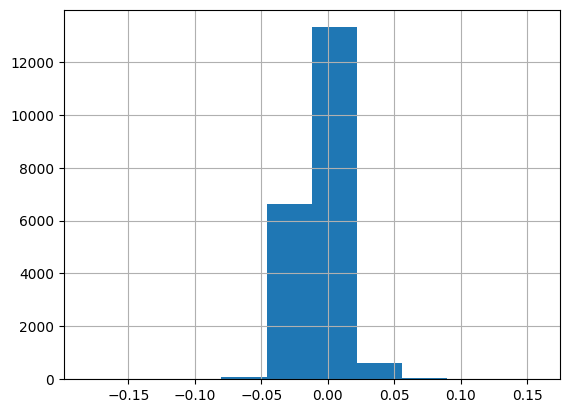

In [21]:
# distribution 
corr.hist()

C:\Users\matte\AppData\Local\Temp\ipykernel_27884\2376095469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_positive_corr.index, y=top_positive_corr.values, palette="coolwarm")


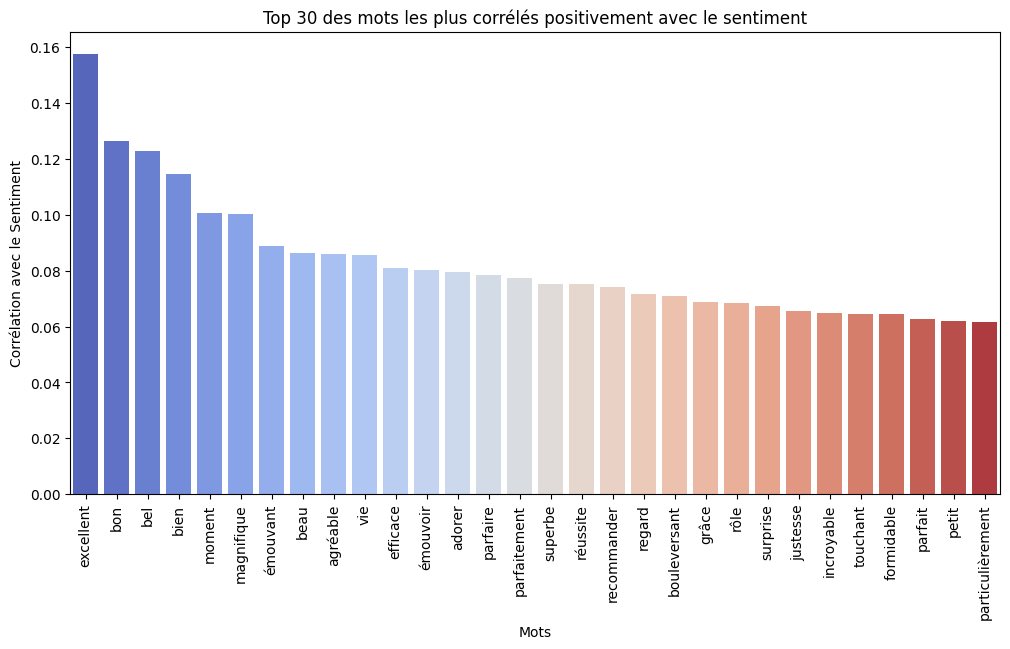

In [22]:
# Sélectionner les 30 mots ayant la plus forte corrélation positive
top_positive_corr = corr.sort_values(ascending=False).head(30)

# Tracer un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(x=top_positive_corr.index, y=top_positive_corr.values, palette="coolwarm")

# Faire pivoter les étiquettes de l'axe X pour améliorer la lisibilité
plt.xticks(rotation=90)
plt.xlabel("Mots")
plt.ylabel("Corrélation avec le Sentiment")
plt.title("Top 30 des mots les plus corrélés positivement avec le sentiment")

# Afficher le graphique
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_27884\1211727892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_negative_corr.index, y=top_negative_corr.values, palette="coolwarm")


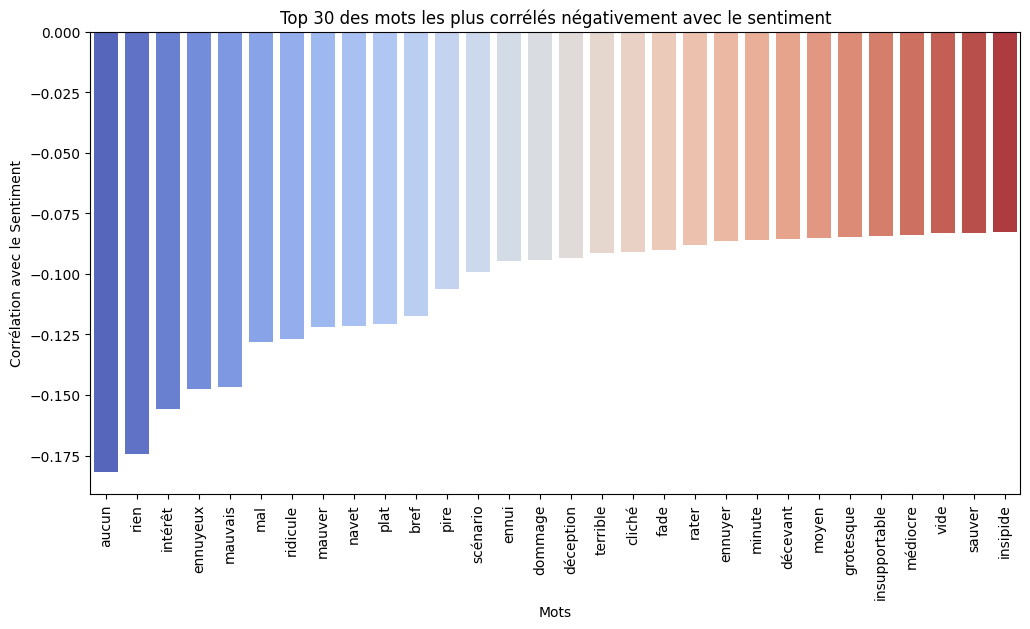

In [23]:
# Sélectionner les 30 mots ayant la plus forte corrélation négative
top_negative_corr = corr.sort_values(ascending=True).head(30)

# Tracer un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(x=top_negative_corr.index, y=top_negative_corr.values, palette="coolwarm")

# Faire pivoter les étiquettes de l'axe X pour améliorer la lisibilité
plt.xticks(rotation=90)
plt.xlabel("Mots")
plt.ylabel("Corrélation avec le Sentiment")
plt.title("Top 30 des mots les plus corrélés négativement avec le sentiment")

# Afficher le graphique
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_27884\21198452.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neutral_corr.index, y=top_neutral_corr.values, palette="coolwarm")


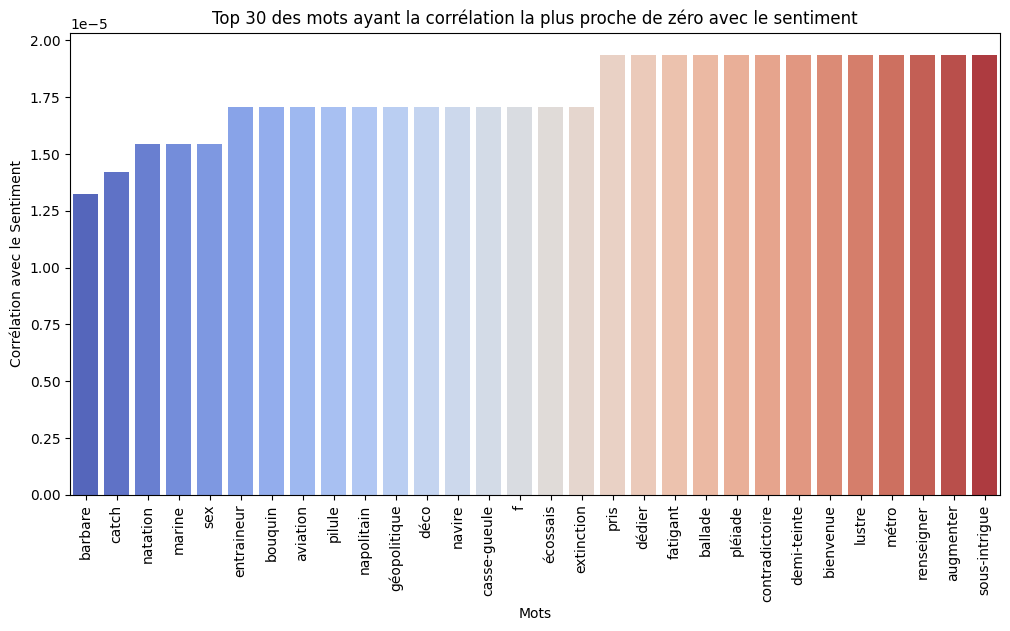

In [24]:
# Sélectionner les 30 mots ayant la corrélation la plus proche de zéro
top_neutral_corr = corr.reindex(corr.abs().sort_values(ascending=True).index).head(30)

# Tracer un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(x=top_neutral_corr.index, y=top_neutral_corr.values, palette="coolwarm")

# Faire pivoter les étiquettes de l'axe X pour améliorer la lisibilité
plt.xticks(rotation=90)
plt.xlabel("Mots")
plt.ylabel("Corrélation avec le Sentiment")
plt.title("Top 30 des mots ayant la corrélation la plus proche de zéro avec le sentiment")

# Afficher le graphique
plt.show()

In [25]:
corr.describe()

count    20707.000000
mean        -0.000337
std          0.015135
min         -0.181747
25%         -0.012935
50%          0.001464
75%          0.009714
max          0.157497
dtype: float64

In [26]:
# Maintenant on supprime les mots avec une correlation <= abs(esp), Attention on doit eviter d'avoir des critiques vides a la fin
# On ne le fait pas finalement trop complexe à gerer (phrase trop petite)
"""def is_useless(corr_value, esp=1e-3):
    return corr_value >= - esp  and corr_value <= esp
esp = 0.001
ban_words = []
top_neutral_corr = corr.reindex(corr.abs().sort_values(ascending=True).index)
for word, corr_value in top_neutral_corr.items():
    if is_useless(corr_value, esp=esp):
        ban_words.append(word)
    else:
        break

print(f"Nombre de mots bannis : {len(ban_words)}")
print(f"Nombre de mots bannis : {round(100*len(ban_words)/corr.values.size, 2)}%")
"""

'def is_useless(corr_value, esp=1e-3):\n    return corr_value >= - esp  and corr_value <= esp\nesp = 0.001\nban_words = []\ntop_neutral_corr = corr.reindex(corr.abs().sort_values(ascending=True).index)\nfor word, corr_value in top_neutral_corr.items():\n    if is_useless(corr_value, esp=esp):\n        ban_words.append(word)\n    else:\n        break\n\nprint(f"Nombre de mots bannis : {len(ban_words)}")\nprint(f"Nombre de mots bannis : {round(100*len(ban_words)/corr.values.size, 2)}%")\n'

# Préprocessing final / custom tokenizer

In [27]:
def tokenize(text : str)->list:
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    # first on remove les NER
    for ent in doc.ents:
        for i in range(ent.end-ent.start):
            tokens[i+ent.start] = False

    # après la ponctuation et les stop_words
    for i, token in enumerate(doc):
        if token.is_stop or token.pos_ == 'PUNCT':
            tokens[i] = False 
        elif token.lemma_  == '/': 
            tokens[i] = False

    tokens = [tokens[i] for i in range(len(tokens)) if tokens[i] != False]
    assert len(tokens) > 1 # verifiez que c utilisable
    
    return tokens

In [28]:
text = df['contenu'].iloc[3]
print('text before :', text)
print('vector :', tokenize(text))

text before : Un film québécois avec le français et l'intonation de là-bas, sous-titré en français d’ici au début du fait de l’élocution (trop) rapide et de quelques expressions du cru, ça attire toujours l’attention du cinéphile . Car c’est un cinéma qui a souvent produit des pépites (au-delà de l’éternel et inénarrable Xavier Dolan très grand public) . Mais cette fois-ci, déception . Quand je critique sévèrement avec une note basse en rapport, je me demande toujours si c’est seulement moi qui n’ai pas aimé . Mais en sortant, j’ai entendu un spectateur glisser à sa compagne : « nul » . Comme moi, il n’a pas aimé cette longue scène de début où la caméra collée aux visages tourbillonne dans tous les sens à en donner le tournis au spectateur . Un effet de style dont on se demande quelle est la finalité . Pour ce qui est du fond du scénario, on s’attend à quelque chose d’humoristique, d’ironique ou de caustique, ceci n’empêchant pas la réflexion, sur les travers des mâles misogynes (pléon

# TfidfVectorizer + Regression

In [29]:
dd

NameError: name 'dd' is not defined

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

## chargement des données

In [31]:
del df
data = {
    'train' : None,
    'val' : None,
    'test' : None
}
for df_name in data.keys():
    data[df_name] = pd.read_csv(f"final_dataset/{df_name}.csv", sep='~')

In [32]:
# to thread 
def vectorize_contenu(vectors, i, contenu):
    vectors[i] = " ".join(tokenize(contenu)) # chengement on met en str (tfVectorizer prend des str)


def tokenize_all(set_name, critiques, chunk_size : 10):
    vectors = [None] * critiques.size
    threads = []

    # Create and start threads
    for i in tqdm(range(critiques.size), desc=f"Tokenize {set_name} dataset"):
        contenu = critiques[i]
        thread = threading.Thread(target=vectorize_contenu, args=(vectors,i,contenu,))
        threads.append(thread)
        thread.start()
        

        if len(threads) >= chunk_size:  # peut etre mofiier attention au fuite mémoire / explosion
            for t in threads:
                t.join()   
            threads = []  
        
    # verifi si tout bien finis
    for t in threads:
        t.join()
    return np.array(vectors)

In [33]:
def deleteEmpty(vectors : list, sentiments : list):
    old_size =  len(vectors)
    assert old_size == len(sentiments)
    i = 0
    while i < len(vectors):
        if not vectors[i]:
            vectors = vectors[:i] + vectors[i+1:]
            sentiments = sentiments[:i] + sentiments[i+1:]
        else:
            i += 1
    print(f"delete {old_size-len(vectors)}")
    return np.array(vectors), np.array(sentiments)

In [ ]:
# custom TfidfVectorizer, on tokenize mainetant
X_train, y_train = np.array(data["train"]['contenu']), np.array(data["train"]['sentiment'])
X_val, y_val = np.array(data["val"]['contenu']), np.array(data["val"]['sentiment'])
X_test, y_test = np.array(data["test"]['contenu']), np.array(data["test"]['sentiment'])

# vectorize 
X_train = tokenize_all('train', X_train, 10)
X_val = tokenize_all('val', X_val, 10)
X_test = tokenize_all('test', X_test, 10)

Tokenize train dataset:  52%|█████▏    | 4108/7960 [00:50<00:40, 95.89it/s] Exception in thread Thread-12148 (vectorize_contenu):
Traceback (most recent call last):
  File "C:\Users\matte\.pyenv\pyenv-win\versions\3.10.11\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\matte\.pyenv\myenv\.data_mining\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\matte\.pyenv\pyenv-win\versions\3.10.11\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\matte\AppData\Local\Temp\ipykernel_27884\72218530.py", line 3, in vectorize_contenu
  File "C:\Users\matte\AppData\Local\Temp\ipykernel_27884\1897364138.py", line 18, in tokenize
AssertionError
Tokenize val dataset:   2%|▏         | 50/2654 [00:00<00:51, 50.50it/s]Exception in thread Thread-16066 (vectorize_contenu):
Traceback (most recent call last):
  File "C:\Users\matte\.pyenv\pyenv-win\versions\3.10.1

TypeError: tokenize_all() missing 1 required positional argument: 'chunk_size'

In [ ]:
# removed unprocessable by tf-idf vectors
X_train, y_train = deleteEmpty(list(X_train), list(y_train))
print('-'*100)
X_val, y_val = deleteEmpty(list(X_val), list(y_val))
print('-'*100)
X_test, y_test = deleteEmpty(list(X_test), list(y_test))


## Premier test

### Train

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split())
X_train_tfidf = vectorizer.fit_transform(X_train)

c:\Users\matte\.pyenv\myenv\.data_mining\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
vocab_size = len(vectorizer.named_steps['tfidf'].vocabulary_)
print(f"Taille du dictionnaire (nombre de tokens uniques) : {vocab_size}")

In [ ]:
# exemple de tf - idf sur test
X_test_tfidf = vectorizer.transform(X_test[:5])
df_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf.head()

,-,aborder,absolument,accumuler,agir,aimer,aimé,alcoolisée,amoureux,ancien,...,voir,xavier,zoophile,«,âm,échangiste,élocution,éternel,étoile,”
0,0.000000,0.000000,0.125197,0.000000,0.000000,0.000000,0.000000,0.125197,0.125197,0.000000,...,0.000000,0.000000,0.125197,0.000000,0.000000,0.125197,0.000000,0.000000,0.125197,0.000000
1,0.065401,0.065401,0.000000,0.000000,0.162126,0.000000,0.000000,0.000000,0.000000,0.081063,...,0.081063,0.000000,0.000000,0.000000,0.081063,0.000000,0.000000,0.000000,0.000000,0.081063
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.186685,0.093342,0.000000,0.000000,0.000000,0.115695,0.115695,0.000000,0.000000,0.000000,...,0.000000,0.115695,0.000000,0.115695,0.000000,0.000000,0.115695,0.115695,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.292968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Prédiction

### Evaluation

- creation preprocess finale
- tf-idf + LogisticRegression
- best model
- evaluation 
- save

- camembert + ffnlayer
- evaluation 
- save

- comparaions 
- use case
- rapport
- ppt
- video